# **COMPUTER VISISON**


* `torchvision.datasets` - get dataset and data laoding functions for cv
* `torchvision.models` - get pretrained cv models 
* `torchvivion.transforms` - functions for manipulating vision
* `torch.utils.data.Dataset` - base dataset class for pytorch
* `torch.utls.data.DataLoader` - cretes python iterable over a dataset

In [74]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import helper_function as func

print(torch.__version__)
print(torchvision.__version__)

2.5.0+cu121
0.20.0+cu121


## **Dataset**

**FashionMNIST**


In [75]:
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
)

In [76]:
len(train), len(test)

(60000, 10000)

In [77]:
class_names = train.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [78]:
class_to_rdx = train.class_to_idx
class_to_rdx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Image shape: torch.Size([1, 28, 28]) 
Label: 9


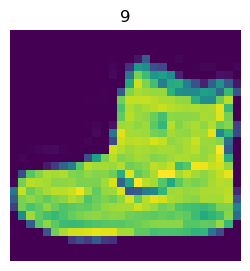

In [79]:
image, label = train[0]
print(f"Image shape: {image.shape} \nLabel: {label}")
plt.figure(figsize=(3,3))
plt.imshow(image[-1])
plt.title(label)
plt.axis(False);

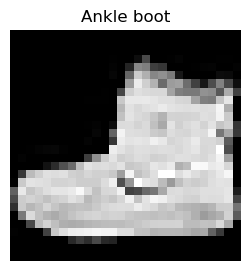

In [80]:
plt.figure(figsize=(3,3))
plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_names[label])
plt.axis(False);

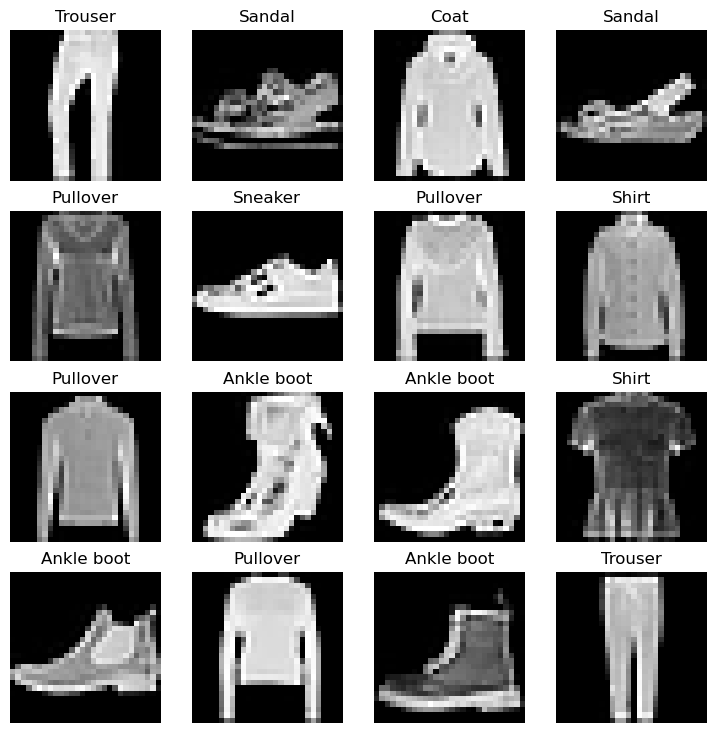

In [81]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0,len(train),size=[1]).item()
    img,label = train[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)
    

## **PREPARE DATALOADER**

In [82]:
BATCH_SIZE = 32
trainDataLoader = DataLoader(dataset=train,batch_size=BATCH_SIZE,shuffle=True)
testDataLoader = DataLoader(dataset=test,batch_size=BATCH_SIZE, shuffle=True)
trainDataLoader, testDataLoader

(<torch.utils.data.dataloader.DataLoader at 0x2995824ab50>,
 <torch.utils.data.dataloader.DataLoader at 0x2992b844490>)

In [83]:
print(f"Length of Train Data Loader is {len(trainDataLoader)} of batches {BATCH_SIZE}")
print(f"Length of Test Data Loader is {len(testDataLoader)} of batches {BATCH_SIZE}")

Length of Train Data Loader is 1875 of batches 32
Length of Test Data Loader is 313 of batches 32


In [84]:
trainfeaturesbatch, trainlabelsbatch = next(iter(trainDataLoader))
trainfeaturesbatch.shape, trainlabelsbatch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## **BASELINE MODEL**

### **Creating baseline model**

In [85]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_unit),
            nn.Linear(in_features=hidden_unit, out_features=output_shape)
        )
        
    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.layer_stack(x)

In [86]:
baseline_model = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_unit=10,
    output_shape=len(class_names)
).to("cpu")
baseline_model

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### **Setting up loss and optimzier**

In [87]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline_model.parameters(), lr = 0.1) 

In [88]:
from timeit import default_timer as timer

In [89]:
def total_time(start: float, end: float, device: torch.device = None) -> float:
    total_time = end - start
    return f"Total time taken is {total_time} seconds "

In [90]:
start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n----')
    trainloss = 0
    # $add a loop to loop through the training batches
    for batch, (x,y) in enumerate (trainDataLoader):
        baseline_model.train()
        trainpred = baseline_model(x)
        loss = loss_fn(trainpred,y)
        trainloss += loss

        optimizer.zero_grad()

        loss.backward()

        if batch % 400 == 0:
            print(f'Looked at {batch*len(x)}/{len(trainDataLoader.dataset)}')

    trainloss /= len(trainDataLoader)
    
    testloss, testacc = 0,0
    baseline_model.eval()
    with torch.inference_mode():
        for xtest,ytest in testDataLoader:
            testpred = baseline_model(xtest)
            testloss += loss_fn(testpred, ytest)
            testacc += func.accuracy_fn(y_true=ytest, y_pred=testpred.argmax(dim=1))
        testloss /= len(testDataLoader)
        testacc /= len(testDataLoader)
        
    print(f"\nTrain Loss: {trainloss:} | Test Loss: {testloss:} | Test Accuracy: {testacc:} ")
    
end = timer()
baseline_time = total_time(start, end,device=str(next(baseline_model.parameters()).device))
baseline_time

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train Loss: 2.2865352630615234 | Test Loss: 2.286548614501953 | Test Accuracy: 19.1194089456869 
Epoch: 1
----
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train Loss: 2.28653621673584 | Test Loss: 2.2864506244659424 | Test Accuracy: 19.159345047923324 
Epoch: 2
----
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train Loss: 2.2865357398986816 | Test Loss: 2.286447525024414 | Test Accuracy: 19.159345047923324 


'Total time taken is 55.325629899976775 seconds '

In [101]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
    device = device,
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            x,y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred,y)
            acc += accuracy_fn(y, ypred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc,
    }

In [92]:
baseline_model_results = eval_model(model=baseline_model,data_loader=testDataLoader,loss_fn=loss_fn,accuracy_fn=func.accuracy_fn)
baseline_model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 2.2864789962768555,
 'model_acc': 19.129392971246006}

## **IMPROVING THE PERFORMANCE**

In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### **Creating new model architecture**

In [94]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features=hidden_unit, out_features=output_shape),
            nn.ReLU(),
            
        )
        
    def forward(self, x: torch.Tensor)->torch.Tensor:
        return self.layer_stack(x)
    

In [95]:
torch.manual_seed(42)
model1 = FashionMNISTModelV1(input_shape=784, hidden_unit=10, output_shape=len(class_names)).to(device)
next(model1.parameters()).device

device(type='cuda', index=0)

### **Setting up loss function and optimizser**

In [96]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.1)

### **Funtionizing training and testing loop**

In [97]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn = func.accuracy_fn,
    device:torch.device = device,
    
    ):
    trainloss, trainacc = 0,0
    model.train()
    for batch, (x,y) in enumerate( data_loader):
        x,y = x.to(device), y.to(device)
        ypred = model(x)
        loss = loss_fn(ypred,y)
        trainloss += loss
        trainacc += accuracy_fn(y, ypred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainloss /= len(data_loader)
    trainacc /= len(data_loader)
    print(f"Train loss: {trainloss:5f} | Train Accuracy: {trainacc:.5f}")

In [98]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn = func.accuracy_fn,
    device :torch.device = device
):
    testloss, testacc = 0,0
    model.eval()
    with torch.inference_mode():
        for x,y in data_loader:
            x,y = x.to(device), y.to(device)
            ypred = model(x)
            testloss += loss_fn(ypred,y)
            testacc += accuracy_fn(y,ypred.argmax(dim=1))
            
        testloss /= len(data_loader)
        testacc /= len(data_loader)
        
        print(f'Test Loss: {testloss:.5f} | Test Accuracy: {testacc} ')

In [99]:
torch.manual_seed(42)
start = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n ----- ')
    train_step(model1,trainDataLoader,loss_fn,optimizer,func.accuracy_fn,device)
    test_step(model1,testDataLoader,loss_fn,func.accuracy_fn,device)
end = timer()
total_time(start, end, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
 ----- 
Train loss: 1.091992 | Train Accuracy: 61.34333
Test Loss: 0.95690 | Test Accuracy: 64.97603833865814 
Epoch: 1
 ----- 
Train loss: 0.737795 | Train Accuracy: 73.69333
Test Loss: 0.72388 | Test Accuracy: 74.21126198083067 
Epoch: 2
 ----- 
Train loss: 0.667762 | Train Accuracy: 76.07667
Test Loss: 0.68751 | Test Accuracy: 75.63897763578275 


'Total time taken is 70.27486250002403 seconds '

In [102]:
results = eval_model(model1, testDataLoader, loss_fn, func.accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6877616047859192,
 'model_acc': 75.63897763578275}

## **USING CONVOLUTON LAYERS**

In [152]:
class FashionMNISTCNNModel(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), 
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # there's a trick to calculating this...
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x) 
    x = self.classifier(x)
    return x

In [153]:
torch.manual_seed(42)
model2 = FashionMNISTCNNModel(input_shape=1,hidden_unit=10,output_shape=len(class_names)).to(device)

TypeError: FashionMNISTCNNModel.__init__() got an unexpected keyword argument 'hidden_unit'

In [154]:
images = torch.randn(size=(32,3,28,28))
test_image = images[0]
print(f'Image batch shape: {images} \nSingle image shape: {test_image.shape} \n test image: {test_image}')

Image batch shape: tensor([[[[ 1.9269,  1.4873,  0.9007,  ...,  1.2964,  0.6105,  1.3347],
          [-0.2316,  0.0418, -0.2516,  ...,  1.1914, -0.8140, -0.7360],
          [-1.4032,  0.0360, -0.0635,  ..., -0.3387, -1.3407, -0.5854],
          ...,
          [-1.2520,  3.0250,  1.3463,  ...,  0.2793,  0.1864,  0.3547],
          [ 0.0906,  1.7423, -1.2660,  ..., -0.8494, -1.6594,  0.3063],
          [ 1.1820,  0.3260, -0.3894,  ...,  0.7693, -0.7669, -0.9495]],

         [[ 0.0169,  0.0803,  0.7448,  ...,  1.4559,  0.3317, -1.0001],
          [-0.6920, -0.4720, -1.2894,  ..., -0.4579, -1.2322, -0.5981],
          [-0.2815,  0.0528,  0.4250,  ..., -2.1582, -1.6608, -0.6637],
          ...,
          [ 0.6738,  1.4666, -1.1077,  ..., -0.2219,  0.5819, -1.9369],
          [-1.5334, -0.1797, -0.6578,  ..., -0.6987, -0.2052, -0.7812],
          [ 0.6873,  0.7836, -1.1109,  ...,  0.4134,  0.0062, -0.5673]],

         [[-0.1704, -0.3028, -1.2868,  ...,  1.5608, -1.0952,  1.1855],
          [

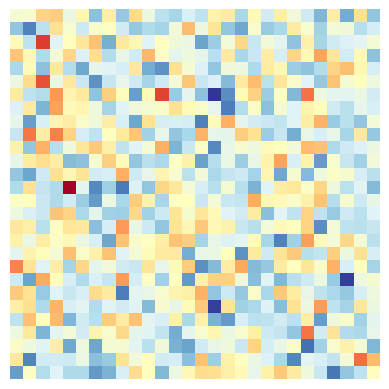

In [155]:
plt.imshow(test_image[-1],cmap='RdYlBu')
plt.axis(False);

In [156]:
with torch.inference_mode():
    y = model2(torch.randn(size=(1,28,28)).to(device)).unsqueeze(0)
    
y.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x49 and 490x10)

In [159]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(),lr=0.1)

In [160]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch} \n--------')
    train_step(model2,trainDataLoader,loss_fn,optimizer,device=device)
    test_step(model2,testDataLoader,loss_fn)
    
end = timer()
total_time(start,end,device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
--------
Train loss: 0.606835 | Train Accuracy: 78.09167
Test Loss: 0.40707 | Test Accuracy: 85.69289137380191 
Epoch: 1 
--------
Train loss: 0.363486 | Train Accuracy: 86.91833
Test Loss: 0.37899 | Test Accuracy: 87.11062300319489 
Epoch: 2 
--------
Train loss: 0.327398 | Train Accuracy: 88.13333
Test Loss: 0.34678 | Test Accuracy: 87.47004792332268 


'Total time taken is 61.04646719992161 seconds '

In [161]:
model2_results = eval_model(
    model2,testDataLoader,loss_fn,func.accuracy_fn,device
)
model2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTCNNModel',
 'model_loss': 0.3463379740715027,
 'model_acc': 87.48003194888179}

In [162]:
import pandas as pd
compare_results = pd.DataFrame ([baseline_model_results,
                                 results,
                                 model2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,2.286479,19.129393
1,FashionMNISTModelV1,0.687762,75.638978
2,FashionMNISTCNNModel,0.346338,87.480032


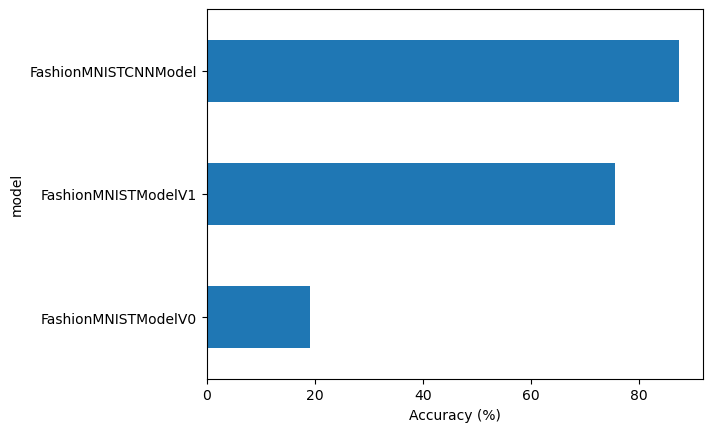

In [164]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy (%)")
plt.ylabel("model");